# Price Prediction

**Loading the python packages**



In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# #Libraries for Deep Learning Models
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.optimizers import SGD


In [133]:
# load dataset
dataset = pd.read_csv('/Users/martinbufi/Documents/batch6-instructors/S02 - Data Wrangling/HCKT02 - Data Wrangling/portal/full_data.csv')

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

**Exploratory Data Analysis**

In [134]:
# shape
dataset.shape
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# describe data
#set_option('precision', 3)
# set precision to 3 places
display.precision = 3
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.999990e+05,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000
mean,1.340318e+09,9.821951,9.824951,9.818321,9.821286,21.021827,206.749281,9.821525
std,8.660245e+06,2.666161,2.667011,2.664901,2.665678,55.478183,547.135377,2.665962
min,1.325318e+09,3.800000,3.800000,3.800000,3.800000,0.000000,0.000000,3.800000
25%,1.332818e+09,7.200000,7.200000,7.200000,7.200000,2.170000,21.019851,7.200000
50%,1.340318e+09,10.800000,10.800000,10.790000,10.790000,7.340000,67.920000,10.793242
75%,1.347818e+09,11.840000,11.840000,11.830000,11.840000,20.240016,199.280000,11.833367
max,1.355318e+09,16.410000,16.410000,15.490000,16.000000,2958.477574,31212.194780,16.386568


**Data Preparation**

In [135]:
#Checking for any null values and removing the null values'''
print('Null Values =', dataset.isnull().values.any())

#dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()
#remove the rows with null values
dataset = dataset.dropna()

#dataset=dataset.drop(columns=['Timestamp'])

print('Null Values =', dataset.isnull().values.any())

Null Values = True
Null Values = False


Preparing the data for classification
We attach a label to each movement:

- 1 if the signal is that short term price will go up as compared to the long term.
- 0 if the signal is that short term price will go down as compared to the long term.

In [136]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].shift(-10).rolling(window=10, min_periods=10, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].shift(-60).rolling(window=60, min_periods=60, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

dataset.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
499939,1355314260,13.34,13.34,13.34,13.34,24.866857,331.723868,13.34,NaN,NaN,0.0
499940,1355314320,13.33,13.33,13.33,13.33,16.881552,225.031092,13.33,NaN,NaN,0.0
499958,1355315400,13.42,13.42,13.42,13.42,5.763040,77.340000,13.42,NaN,NaN,0.0
499961,1355315580,13.34,13.34,13.34,13.34,1.500000,20.010000,13.34,NaN,NaN,0.0
499964,1355315760,13.34,13.34,13.34,13.34,3.900000,52.026000,13.34,NaN,NaN,0.0


**Feature Engineering**

Moving Average : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart.

Stochastic Oscillator %K and %D : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.

Relative Strength Index(RSI) :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.

Rate Of Change(ROC): It is a momentum oscillator, which measures the percentage change between the current price and the n period past price.

Momentum (MOM): It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [137]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [138]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
499939,1355314260,13.34,13.34,13.34,13.34,24.866857,331.723868,13.34,NaN,NaN,...,49.995688,0.000000,0.000000,0.0,0.000000,70.000000,74.444444,13.394,13.406000,13.37065
499940,1355314320,13.33,13.33,13.33,13.33,16.881552,225.031092,13.33,NaN,NaN,...,49.868857,0.000000,0.000000,0.0,0.000000,66.666667,70.000000,13.384,13.404000,13.37030
499958,1355315400,13.42,13.42,13.42,13.42,5.763040,77.340000,13.42,NaN,NaN,...,50.993373,90.000000,30.000000,90.0,30.000000,96.666667,77.777778,13.383,13.405000,13.37040
499961,1355315580,13.34,13.34,13.34,13.34,1.500000,20.010000,13.34,NaN,NaN,...,49.991577,10.000000,33.333333,10.0,33.333333,70.000000,77.777778,13.374,13.403333,13.37005
499964,1355315760,13.34,13.34,13.34,13.34,3.900000,52.026000,13.34,NaN,NaN,...,49.991577,11.111111,37.037037,10.0,36.666667,70.000000,78.888889,13.365,13.401667,13.36975


In [139]:
# Reclean after the new calcs

#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)', 'Volume_(BTC)','short_mavg','long_mavg', 'Weighted_Price'], axis=1)
print('Null Values =', dataset.isnull().values.any())
#dataset = dataset.dropna(axis=0)
#dataset = dataset.reset_index()
#dataset=dataset.drop(columns=['index'])
#print('Null Values =', dataset.isnull().values.any())
  
dataset.tail()

Null Values = True


,Timestamp,Close,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
499939,1355314260,13.34,0.0,13.381654,13.397634,13.370544,-0.670141,-0.373413,-0.09,-0.05,...,49.995688,0.000000,0.000000,0.0,0.000000,70.000000,74.444444,13.394,13.406000,13.37065
499940,1355314320,13.33,0.0,13.372263,13.393270,13.370141,-0.744602,-0.448096,-0.10,-0.06,...,49.868857,0.000000,0.000000,0.0,0.000000,66.666667,70.000000,13.384,13.404000,13.37030
499958,1355315400,13.42,0.0,13.380942,13.394995,13.370637,-0.074460,0.224048,-0.01,0.03,...,50.993373,90.000000,30.000000,90.0,30.000000,96.666667,77.777778,13.383,13.405000,13.37040
499961,1355315580,13.34,0.0,13.373498,13.391447,13.370332,-0.670141,-0.373413,-0.09,-0.05,...,49.991577,10.000000,33.333333,10.0,33.333333,70.000000,77.777778,13.374,13.403333,13.37005
499964,1355315760,13.34,0.0,13.367408,13.388128,13.370030,-0.373413,-0.373413,-0.09,-0.05,...,49.991577,11.111111,37.037037,10.0,36.666667,70.000000,78.888889,13.365,13.401667,13.36975


In [140]:
# IGNORE THIS CELL. This is for splitting data for students until we are happy with result.

# split data set to train and test data sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size,:], dataset.iloc[train_size:len(dataset),:]
print(len(train), len(test))

# scrape dataset will have the following columns RSI30, ROC30, MOM30, EMA200
scrape_dataset = train[['Timestamp','EMA200', 'MA200', 'RSI200', '%K30']]

# api dataset will have the following columns RSI100,%K200,%K30, EMA10
api_dataset = train[['Timestamp','EMA30', 'MA30', 'EMA10', '%D10']]

# database data will have the folloing columns %D30,%D200,ROC10, MA21
database_dataset = train[['Timestamp','MA10', 'RSI30', 'RSI10', '%K10']]

# check length of all datasets
print(len(scrape_dataset), len(api_dataset), len(database_dataset))

# export the dataframes to csv files
scrape_dataset.to_csv('scrape_dataset.csv', index=False)
api_dataset.to_csv('api_dataset.csv', index=False)
database_dataset.to_csv('database_dataset.csv', index=False)

# remove all used columns in past dataframes from base dataset
train = train.drop(['EMA200', 'MA252', 'RSI200', '%K30', 'EMA30', 'MA63', 'EMA10', '%D10', 'MA21', 'RSI30', 'RSI10', '%K10'], axis=1)
#test = test.drop(['RSI30', 'ROC30', 'MOM30', 'EMA200', 'RSI10', '%K200', '%K30', 'EMA10', '%D30', '%D200', 'ROC10', 'MA21'], axis=1)

# answer key for signal
signal_answers = test[['Timestamp','signal']]

# remove signal column from test data set 
test = test.drop(['signal'], axis=1)

# export train and test data sets to csv files
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
signal_answers.to_csv('signal_test.csv', index=False)

19616 4905
19616 19616 19616


In [141]:
#split train into 4 equal chunks
train1 = train.iloc[0:train_size//4,:]
train2 = train.iloc[train_size//4:train_size//2,:]
train3 = train.iloc[train_size//2:train_size//4*3,:]
train4 = train.iloc[train_size//4*3:train_size,:]
# save each
train1.to_csv('train1.csv', index=False)
train2.to_csv('train2.csv', index=False)
train3.to_csv('train3.csv', index=False)
train4.to_csv('train4.csv', index=False)

# get test data set, remove all columns except "Timestamp"
test = test[['Timestamp']]
# add new column named signal
test['signal'] = 1.0
# save to csv
test.to_csv('sample_submission.csv', index=False)

In [161]:
# CHECK BEFORE MERGING

sub_train_1 = pd.read_csv('/Users/martinbufi/Documents/batch6-instructors/S02 - Data Wrangling/HCKT02 - Data Wrangling/data/train1.csv')
sub_train_2 = pd.read_csv('/Users/martinbufi/Documents/batch6-instructors/S02 - Data Wrangling/HCKT02 - Data Wrangling/data/train2.csv')
sub_train_3 = pd.read_csv('/Users/martinbufi/Documents/batch6-instructors/S02 - Data Wrangling/HCKT02 - Data Wrangling/data/train3.csv')
sub_train_4 = pd.read_csv('/Users/martinbufi/Documents/batch6-instructors/S02 - Data Wrangling/HCKT02 - Data Wrangling/data/train4.csv')
full_train = pd.read_csv('/Users/martinbufi/Documents/batch6-instructors/S02 - Data Wrangling/HCKT02 - Data Wrangling/data/train.csv')


# check datasets merge correctly
# merge the train 1 -4 datasets together
sub_train = pd.concat([sub_train_1, sub_train_2, sub_train_3, sub_train_4])
print(len(sub_train))

print(len(sub_train) == len(full_train))

scrape_dataset = pd.read_csv('/Users/martinbufi/Documents/batch6-instructors/S02 - Data Wrangling/HCKT02 - Data Wrangling/portal/scrape_dataset.csv')
api_dataset = pd.read_csv('/Users/martinbufi/Documents/batch6-instructors/S02 - Data Wrangling/HCKT02 - Data Wrangling/portal/api_dataset.csv')
database_dataset = pd.read_csv('/Users/martinbufi/Documents/batch6-instructors/S02 - Data Wrangling/HCKT02 - Data Wrangling/portal/database_dataset.csv')

#check the length of each dataset equals to the full_train dataset
print(len(scrape_dataset) == len(full_train))
print(len(api_dataset) == len(full_train))
print(len(database_dataset) == len(full_train))

# merge the 3 datasets together
portal_dataset = pd.merge(scrape_dataset, api_dataset, on='Timestamp')
portal_dataset = pd.merge(portal_dataset, database_dataset, on='Timestamp')
print(len(portal_dataset))

# merge the portal dataset with the full train dataset
full_train = pd.merge(full_train, portal_dataset, on='Timestamp')

# check number of columns not including TimeStamp and Signal
print(len(full_train.columns) - 2)


testing_dataset = pd.read_csv('/Users/martinbufi/Documents/batch6-instructors/S02 - Data Wrangling/HCKT02 - Data Wrangling/data/test.csv')
print(len(testing_dataset))

#merge the testing dataset with the full train dataset
full_train = pd.merge(full_train, testing_dataset, on='Timestamp')
print(full_train.head())

# finnaly, check the length of the full_train dataset compare to the original dataset
print(len(full_train))
print(len(dataset))
print(len(full_train) == len(dataset))

19616
True
True
True
True
19616
20
4905
Empty DataFrame
Columns: [Timestamp, Close_x, signal, ROC10_x, ROC30_x, MOM10_x, MOM30_x, %D30_x, %K200_x, %D200_x, EMA200_x, MA252_x, RSI200_x, %K30_x, EMA30_x, MA63_x, EMA10_x, %D10_x, MA21_x, RSI30_x, RSI10_x, %K10_x, Close_y, EMA10_y, EMA30_y, EMA200_y, ROC10_y, ROC30_y, MOM10_y, MOM30_y, RSI10_y, RSI30_y, RSI200_y, %K10_y, %D10_y, %K30_y, %D30_y, %K200_y, %D200_y, MA21_y, MA63_y, MA252_y]
Index: []

[0 rows x 42 columns]
0
24521
False


**Data Visualization**

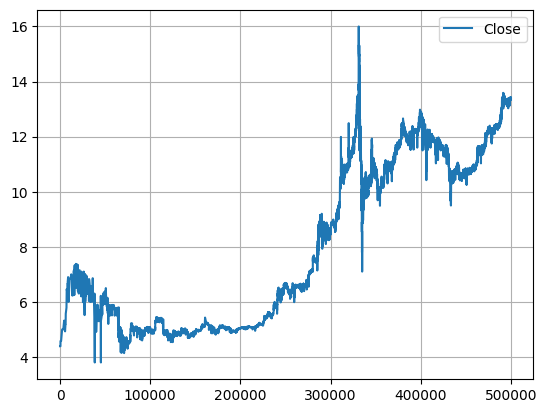

In [107]:
dataset[['Close']].plot(grid=True)
plt.show()

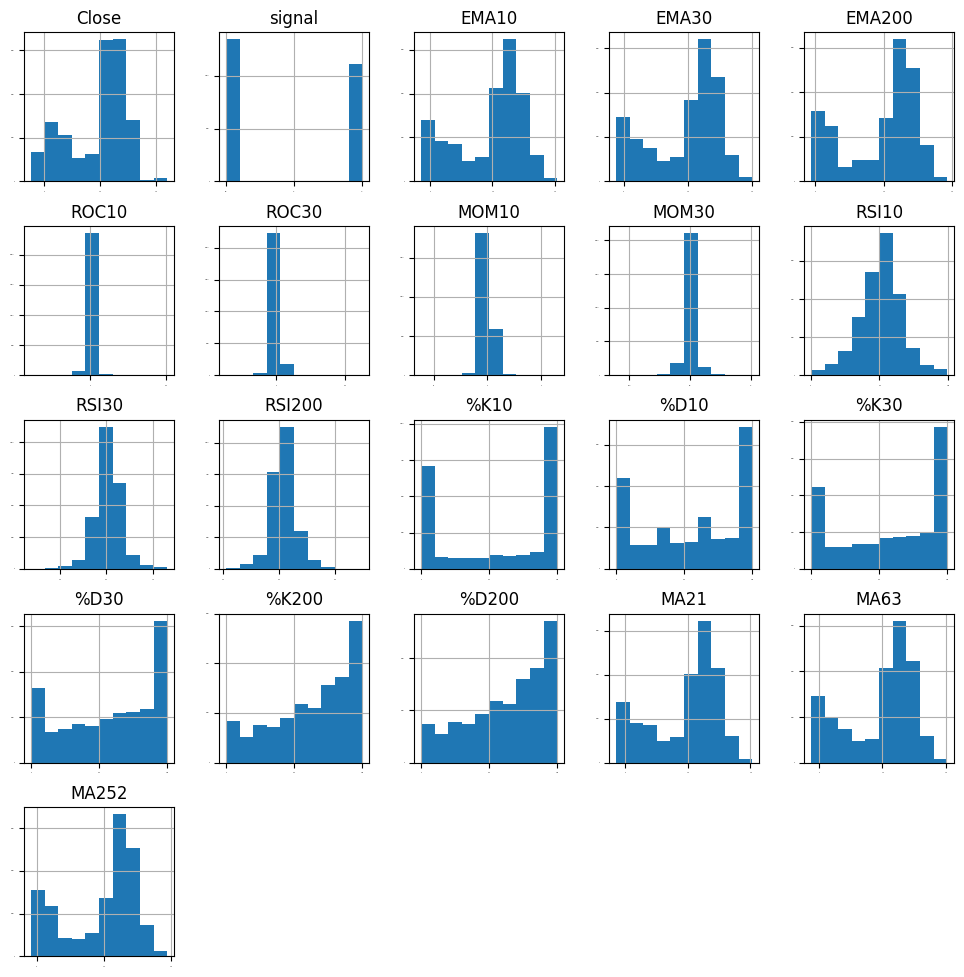

In [108]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

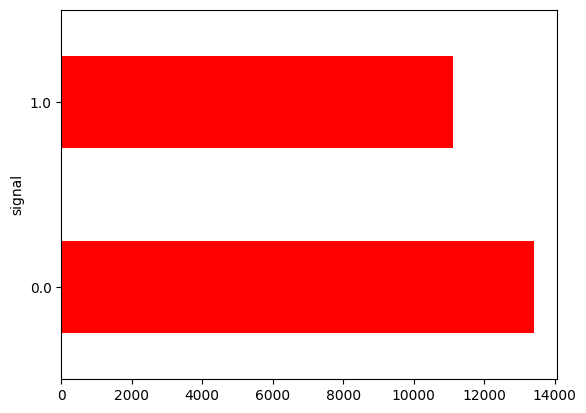

In [48]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

The predicted variable is downward N% out of total data-size, meaning that number of the buy signals were less than the number of sell signals.



<AxesSubplot:title={'center':'Correlation Matrix'}>

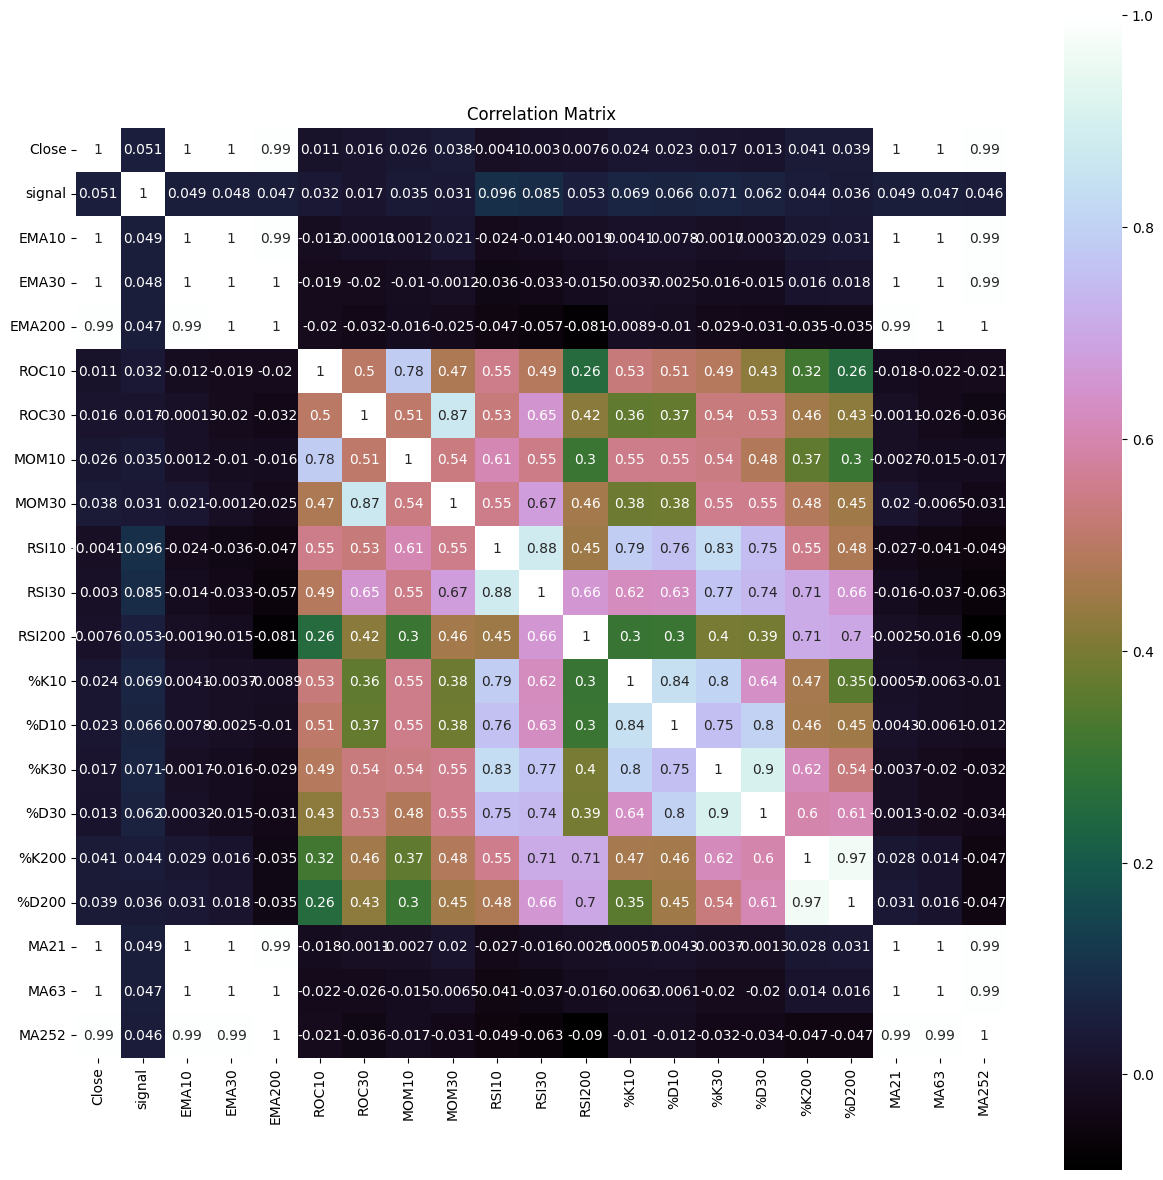

In [109]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

**Evaluate Algorithms and Models**

In [110]:
dataset = dataset.dropna(axis=0)
dataset = dataset.reset_index()
dataset=dataset.drop(columns=['index'])

# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [111]:
# test options for classification
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
scoring = 'roc_auc'

In order to know which algorithm technic is the best for our strategy, we evaluate following non linear different methods:



In [112]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
# Ensamble Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [113]:
# K-folds cross validation
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring, error_score="raise")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/Users/martinbufi/miniconda3/envs/obb/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martinbufi/miniconda3/envs/obb/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

LR: 0.561652 (0.018869)
LDA: 0.567424 (0.021043)
KNN: 0.703915 (0.010513)
CART: 0.849270 (0.012284)
NB: 0.572312 (0.017212)
NN: 0.584517 (0.015862)
AB: 0.665824 (0.015061)
GBM: 0.777796 (0.010296)
RF: 0.970440 (0.002339)


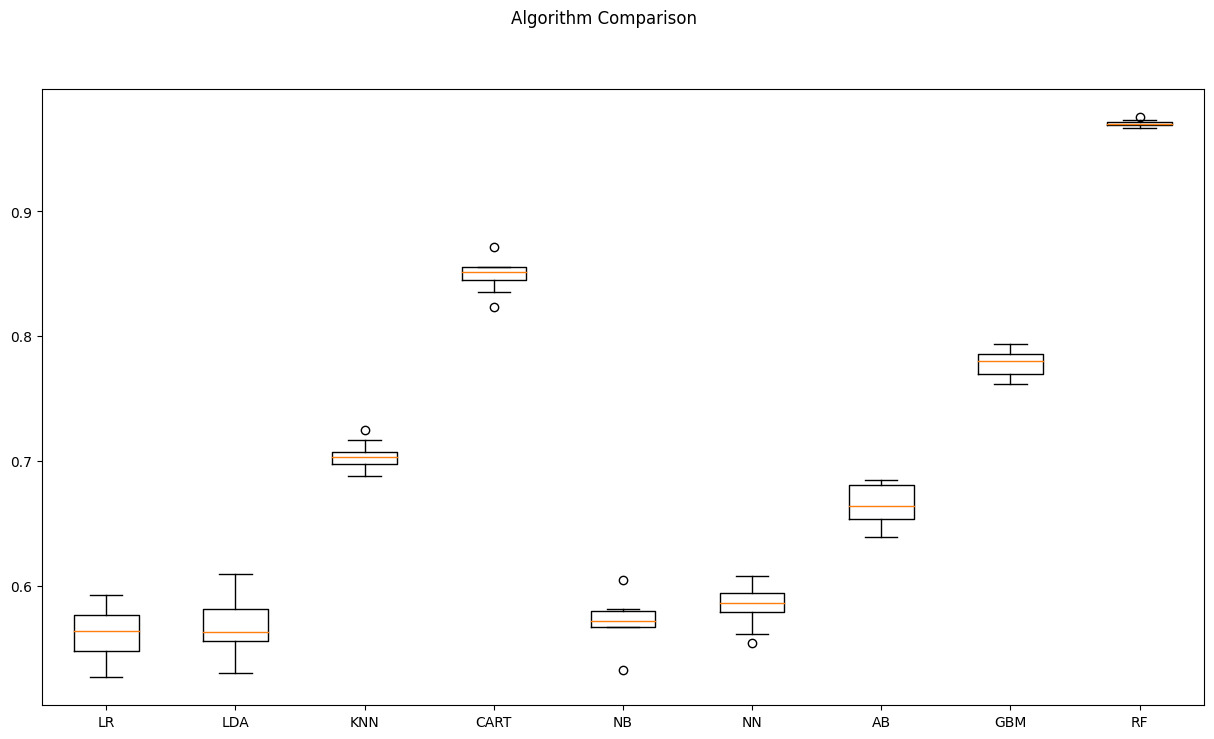

In [114]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

**Model Tuning and Grid Search**

Random forest is selected for the grid search as it is one of the best models out of all.


In [115]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.881423 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#6 0.694115 (0.013267) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.696739 (0.015461) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.866259 (0.007974) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.881423 (0.004333) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.687903 (0.015457) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#7 0.690933 (0.015891) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.855475 (0.008132) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#2 0.869148 (0.004518) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


Finalizing the model with best parameters found during tuning step.



In [116]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [117]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(roc_auc_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.798199009814013
[[2263  315]
 [ 589 1504]]
              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83      2578
         1.0       0.83      0.72      0.77      2093

    accuracy                           0.81      4671
   macro avg       0.81      0.80      0.80      4671
weighted avg       0.81      0.81      0.80      4671



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

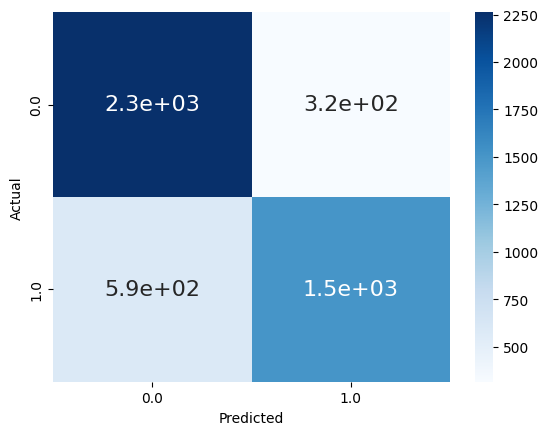

In [118]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

**Variable Intuition/Feature Importance**

Text(0.5, 0, 'Variable Importance')

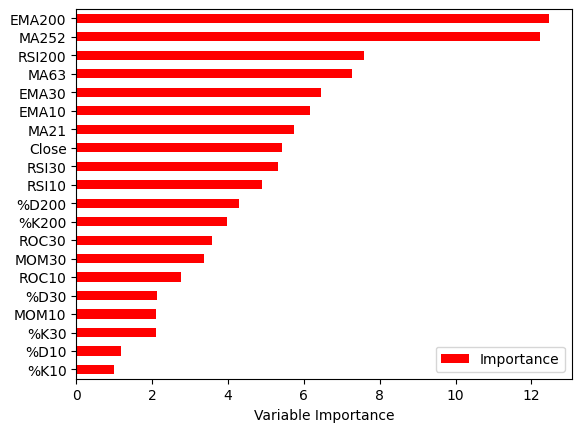

In [119]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

**Backtesting Results**

<AxesSubplot:>

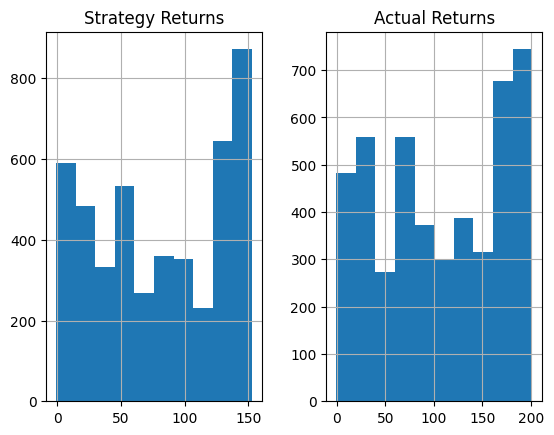

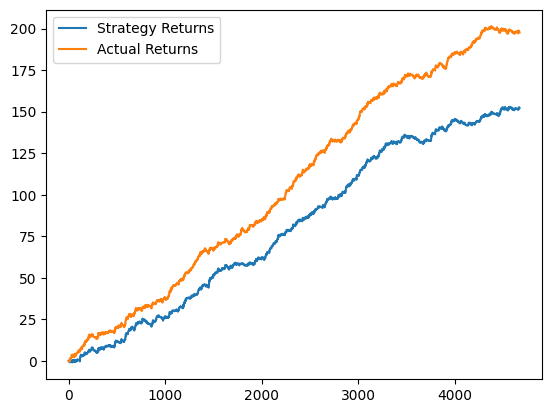

In [120]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()